In [1]:
import pandas as pd
import numpy as np

# Minimize a function using the downhill simplex algorithm
from scipy.optimize import fmin
from scipy.special import lambertw
from scipy.stats import kurtosis, norm

import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm

import yfinance as yf
import random

# Displaying plots in jupyter notebook
%matplotlib inline
plt.rcParams.update({'figure.figsize': (7,5), 'figure.dpi': 100}) #Controls size and resolution of plots

device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
random.seed(42) # for reproduceability on multiple runs 
torch.manual_seed(42) # same as above for weight initializations, shuffling of data, etc




In [2]:
# The ticker and time period of our data can be freely modified 
ticker = "MSFT"
sp500 = yf.download(ticker, '2009-05-01', '2024-10-30')
sp500

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-05-01,20.190001,20.350000,19.860001,20.240000,14.990584,63224500
2009-05-04,20.370001,20.400000,19.980000,20.190001,14.953554,54313400
2009-05-05,20.139999,20.240000,19.639999,19.790001,14.657293,66835500
2009-05-06,20.059999,20.070000,19.610001,19.790001,14.657293,59639100
2009-05-07,19.959999,19.990000,19.139999,19.320000,14.309195,68727200
...,...,...,...,...,...,...
2024-10-23,430.859985,431.079987,422.529999,424.600006,423.751801,19654400
2024-10-24,425.329987,425.980011,422.399994,424.730011,423.881561,13581600
2024-10-25,426.760010,432.519989,426.570007,428.149994,427.294708,16899100


## Distribution of sp500 log returns


Date
2009-05-04   -0.002473
2009-05-05   -0.020011
2009-05-06    0.000000
2009-05-07   -0.024036
2009-05-08    0.005163
Name: Close, dtype: float64


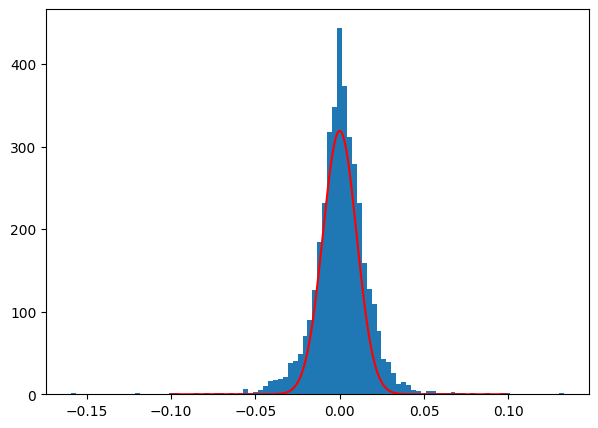

In [3]:
sp500log = np.log(sp500['Close']/sp500['Close'].shift(1))[1:]
print(sp500log.head())

#Lets look at the distribution of the log returns
plt.hist(sp500log.values, bins = 100) 
x_axis = np.arange(-0.1, 0.1, 0.001) #step size of 0.001 from -0.1 to 0.1 to plot our log returns
plt.plot(x_axis, norm.pdf(x_axis, 0, 0.01) * 8, color = 'r') #The PDF at x = 0 is approximately 39.89 given the small std, thus explaining the red curve
plt.show()


We can see from the previous plot that 
- The histogram of the log returns shows more frequent extreme values than the red line
- The histoogram has a higher peak, implying more values concentrated around the mean 

Therefore, we use an inverse Lambert transformation and re-normalization using IGMM algorithm. 

The **inverse Lambert W transform** effectively reduces the heaviness of the taiils, thus bringing the data closer to normality 

The **IGMM**(Iterative Gaussian Mixture Model) algorithm is used together with the **inverse Lambert W transform**  to iteratively estimate the parameters required for the transformation to convert the data to a more a "Gaussian" like distribution.

The code below is referenced from https://github.com/KseniaKingsep/quantgan/blob/main/QuantGAN.ipynb, we will simply reuse the code here

In [4]:
"""
Utility code from Greg Ver Steeg.
Transform data so that it is approximately normally distributed
"""

from typing import Text, List, Union

import numpy as np
from scipy import special
from scipy.stats import kurtosis, norm, rankdata, boxcox
from scipy import optimize  # TODO: Explore efficacy of other opt. methods
import sklearn
from matplotlib import pylab as plt
from scipy import stats
import warnings
import os

def _update_x(x: Union[np.ndarray, List]) -> np.ndarray:
    x = np.asarray(x)
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    elif len(x.shape) != 2:
        raise ValueError("Data should be a 1-d list of samples to transform or a 2d array with samples as rows.")
    return x

class Gaussianize(sklearn.base.TransformerMixin):
    """
    Gaussianize data using various methods.

    Conventions
    ----------
    This class is a wrapper that follows sklearn naming/style (e.g. fit(X) to train).
    In this code, x is the input, y is the output. But in the functions outside the class, I follow
    Georg's convention that Y is the input and X is the output (Gaussianized) data.

    Parameters
    ----------
    
    strategy : str, default='lambert'. Possibilities are 'lambert'[1], 'brute'[2] and 'boxcox'[3].

    tol : float, default = 1e-4

    max_iter : int, default = 100
        Maximum number of iterations to search for correct parameters of Lambert transform.

    Attributes
    ----------
    coefs_ : list of tuples
        For each variable, we have transformation parameters.
        For Lambert, e.g., a tuple consisting of (mu, sigma, delta), corresponding to the parameters of the
        appropriate Lambert transform. Eq. 6 and 8 in the paper below.

    References
    ----------
    [1] Georg M Goerg. The Lambert Way to Gaussianize heavy tailed data with
                        the inverse of Tukey's h transformation as a special case
        Author generously provides code in R: https://cran.r-project.org/web/packages/LambertW/
    [2] Valero Laparra, Gustavo Camps-Valls, and Jesus Malo. Iterative Gaussianization: From ICA to Random Rotations
    [3] Box cox transformation and references: https://en.wikipedia.org/wiki/Power_transform
    """

    def __init__(self, strategy: Text = 'lambert', 
                 tol: float = 1e-5, 
                 max_iter: int = 100, 
                 verbose: bool = False):
        self.tol = tol
        self.max_iter = max_iter
        self.strategy = strategy
        self.coefs_ = []  # Store tau for each transformed variable
        self.verbose = verbose
        
    def fit(self, x: np.ndarray, y=None):
        """Fit a Gaussianizing transformation to each variable/column in x."""
        # Initialize coefficients again with an empty list.  Otherwise
        # calling .fit() repeatedly will augment previous .coefs_ list.
        self.coefs_ = []
        x = _update_x(x)
        if self.verbose:
            print("Gaussianizing with strategy='%s'" % self.strategy)
        
        if self.strategy == "lambert":
            _get_coef = lambda vec: igmm(vec, self.tol, max_iter=self.max_iter)
        elif self.strategy == "brute":
            _get_coef = lambda vec: None   # TODO: In principle, we could store parameters to do a quasi-invert
        elif self.strategy == "boxcox":
            _get_coef = lambda vec: boxcox(vec)[1]
        else:
            raise NotImplementedError("stategy='%s' not implemented." % self.strategy)

        for x_i in x.T:
            self.coefs_.append(_get_coef(x_i))

        return self

    def transform(self, x: np.ndarray) -> np.ndarray:
        """Transform new data using a previously learned Gaussianization model."""
        x = _update_x(x)
        if x.shape[1] != len(self.coefs_):
            raise ValueError("%d variables in test data, but %d variables were in training data." % (x.shape[1], len(self.coefs_)))

        if self.strategy == 'lambert':
            return np.array([W_params(x_i, tau_i) for x_i, tau_i in zip(x.T, self.coefs_)]).T
        elif self.strategy == 'brute':
            return np.array([norm.ppf((rankdata(x_i) - 0.5) / len(x_i)) for x_i in x.T]).T
        elif self.strategy == 'boxcox':
            return np.array([boxcox(x_i, lmbda=lmbda_i) for x_i, lmbda_i in zip(x.T, self.coefs_)]).T
        else:
            raise NotImplementedError("stategy='%s' not implemented." % self.strategy)

    def inverse_transform(self, y: np.ndarray) -> np.ndarray:
        """Recover original data from Gaussianized data."""
        if self.strategy == 'lambert':
            return np.array([inverse(y_i, tau_i) for y_i, tau_i in zip(y.T, self.coefs_)]).T
        elif self.strategy == 'boxcox':
            return np.array([(1. + lmbda_i * y_i) ** (1./lmbda_i) for y_i, lmbda_i in zip(y.T, self.coefs_)]).T
        else:
            raise NotImplementedError("Inversion not supported for gaussianization transform '%s'" % self.strategy)

    def qqplot(self, x: np.ndarray, prefix: Text = 'qq', output_dir: Text = "/tmp/"):
        """Show qq plots compared to normal before and after the transform."""
        x = _update_x(x)
        y = self.transform(x)
        n_dim = y.shape[1]
        for i in range(n_dim):
            stats.probplot(x[:, i], dist="norm", plot=plt)
            plt.savefig(os.path.join(output_dir, prefix + '_%d_before.png' % i))
            plt.clf()
            stats.probplot(y[:, i], dist="norm", plot=plt)
            plt.savefig(os.path.join(output_dir, prefix + '_%d_after.png' % i))
            plt.clf()



# Here if Fisher's definition is used, then we subtract 3.0 from the result to get 0.0 for a normal distributiion
# If bias is false, then we use k-statistics to calculate the bias, providing a unbiased estimate of the kurtosis to elimate bias arising from using sample moments if sample is too small
def delta_init(z):
    k = kurtosis(z, fisher = False, bias = False)
    
    # Delta is an indicator of how skewed the current distribution is, and a bigger delta would be required if the distribution is heavily skewed
    # If the delta is not finite, then we set the value of 0.01
    with np.errstate(all='ignore'):
        delta0 = np.clip(1. / 66 * (np.sqrt(66 * k - 162.) - 6.), 0.01, 0.48)
    if not np.isfinite(delta0):
        delta0 = 0.01
    return delta0
   
def delta_gmm(z):
    # Alg. 1, Appendix C
    delta = delta_init(z)

    def iter(q):
        u = W_delta(z, np.exp(q))
        if not np.all(np.isfinite(u)):
            return 0.
        k = kurtosis(u, fisher=True, bias=False)**2
        if not np.isfinite(k) or k > 1e10:
            return 1e10
        return k

    res = optimize.fmin(iter, np.log(delta), disp=0)
    return np.around(np.exp(res[-1]), 6)

# Look at Lemma 2.5 of Georg's paper, where he details how to inverse a heavy-tailed Lambert W x F_{X} random variable back to Gaussian
def W_delta(z, delta):
    if delta < 1e-6:
        return z
    return np.sign(z) * np.sqrt(np.real(special.lambertw(delta * z ** 2)) / delta)

def W_params(z, params): 
    return params[0] + params[1] * W_delta((z - params[0]) / params[1], params[2])

#In this case, the "inverse" is actually the lambert transformation to transform our Gaussian data back to the heavy tailed distribution that is our log returns 
def inverse(z, params):
    z = (z - params[0]) / params[1]
    return params[0] + params[1] * (z * np.exp(z * z * (params[2] * 0.5)))

def igmm(z, eps=1e-6, max_iter=100):
    # Infer mu, sigma, delta using IGMM in Alg.2, Appendix C    
    delta = delta_init(z)
    params = [np.median(z), np.std(z) * (1. - 2. * delta) ** 0.75, delta]
    for k in range(max_iter):
        params_old = params
        u = (z - params[0]) / params[1]
        params[2] = delta_gmm(u)
        x = W_params(z, params)
        params[0], params[1]  = np.mean(x), np.std(x)

        if np.linalg.norm(np.array(params) - np.array(params_old)) < eps:
            break
        if k == max_iter - 1:
            raise "Solution not found"

    return params

In [5]:
# from gaussianize import *
from sklearn.preprocessing import StandardScaler

log_returns = sp500log.to_numpy().reshape(-1, 1)
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()
sp500processed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))
receptive_field_size = 127  # p. 17
data_size = log_returns.shape[0]
print(sp500processed.shape)
print(data_size)

(3900, 1)
3900


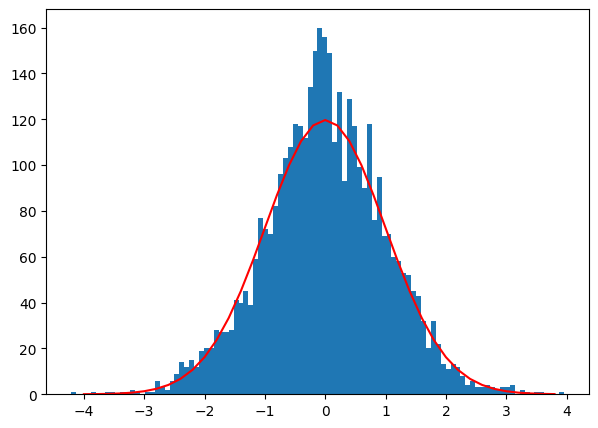

In [6]:
plt.hist(sp500processed, bins= 100)
x_axis = np.arange(-4, 4, 0.2)
plt.plot(x_axis, norm.pdf(x_axis, 0, 1) * 300, color= 'r')
plt.show()
     

## Implementing our TCN model with skip connections





In [7]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm

# We usually pad the input layer by D(K-1), which is the same as D for a kernel size of 2 and 0 for a kernel size of 1.
class Chomp1D(nn.Module):
    def __init__(self, chomp_size): 
        super(Chomp1D, self).__init__() #inherit methods of nn.module
        self.chomp_size = chomp_size
    def forward(self,x):
        # first : represents batch dimension, second : for channel dimension and the last is for the length of the tensor 
        return x[:, :, :-self.chomp_size].contiguous() 
    
class TemporalBlock(nn.Module):
    """Creates a temporal block.
    Args:
        n_inputs (int): number of input channels
        n_outputs (int): number of hidden features
        kernel_size (int): kernel size along temporal axis of convolution layers within the temporal block.
        dilation (int): dilation of convolution layers along temporal axis within the temporal block.
        padding (int): padding
        dropout (float): dropout rate
    Returns:
        tuple of output layers
    """
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout = 0.2):
        super(TemporalBlock, self).__init__()
        
        # Initialise our 2 convolution layers followed by activation functions
        # We use weight_norm to decouple the magnitude from the direction of the weights. Mostly just for improved gradient flows and faster convergence
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size, stride, padding, dilation))
        self.chomp1 = Chomp1D(padding) #Remove the padding for the first layer
        self.relu1 = nn.PReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size, stride, padding, dilation))
        self.chomp2 = Chomp1D(padding) #Remove the padding for the first layer
        self.relu2 = nn.PReLU()
        self.dropout2 = nn.Dropout(dropout) 
        
        if padding == 0: # no need to adjust for padding
            self.net = nn.Sequential(self.conv1, self.relu1, self.dropout1, self.conv2, self.relu2, self.dropout2)
        else:
            self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1, self.conv2, self.chomp2, self.relu2, self.dropout2)
        
        #We also need to define our skip connection, which is a 1x1 convolutional layer to scale from the input from N_{I} to N_{O} to be added to the output of our temporal block
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.PReLU() #for the last layer
        self.init_weights()
    
    # Decision to initialise weights with standard dev of 0.5 (which is q large) is probably an empirical one, can dig into this more
    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.5)
        self.conv2.weight.data.normal_(0, 0.5)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.5)

    def forward(self, x):
        output = self.net(x)
        res = x if self.downsample is None else self.downsample(x) # the residual output with downsampling if necessary (just an identity map)
        return output, self.relu(output + res)
    
class Generator(nn.Module):
    """
    Generator: 3 to 1 Causal temporal convolutional network with skip connections.
    This network uses 1D convolutions in order to model multiple timeseries co-dependency.
    """ 
    def __init__(self):
        super(Generator, self).__init__()
        # Recall that the padding is D(K-1), which translates to 0 for our first layer and D for subsequent layers
        self.tcn = nn.ModuleList([TemporalBlock(3,80,kernel_size = 1, stride = 1, dilation = 1, padding = 0), 
                                 *[TemporalBlock(80,80, kernel_size = 2, stride = 1, dilation = i, padding = i) for i in [1, 2, 4, 8, 16, 32]]])
        self.last = nn.Conv1d(80,1, kernel_size = 1, stride = 1, dilation = 1) #standard 1 x 1 convolutional layer
        

    # Here the implementation seems to take the outputs of each temporal block (before adding the skip connection) as our "skip" values
    # We are effectively adding the pre input of the next temporal blocks, and we do not need to perform any convolution since the hidden dimensions are all the same 
    # Therefore, we are essentially summing all our skip connections, adding it to the final output of the whole TCN and applying RELU 
    def forward(self, x):
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x) #updates x and we add the skip connections to a list
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers))
        return x

class Discriminator(nn.Module):
    def __init__(self, seq_length, conv_dropout = 0.05):
        super(Discriminator, self).__init__()
        self.tcn = nn.ModuleList([TemporalBlock(1,80,kernel_size = 1, stride = 1, dilation = 1, padding = 0), 
                                 *[TemporalBlock(80,80, kernel_size = 2, stride = 1, dilation = i, padding = i) for i in [1, 2, 4, 8, 16, 32]]])
        self.last = nn.Conv1d(80,1, kernel_size = 1, stride = 1, dilation = 1) #standard 1 x 1 convolutional layer
        # We will apply it to x, which has a shape of [batch_size, 1, seq_len], to turn it into a shape [batch_size, 1] with the probabilities
        self.to_prob = nn.Sequential(nn.Linear(seq_length, 1), nn.Sigmoid()) 
    
    def forward(self, x):
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x) #updates x and we add the skip connections to a list
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers)) 
        
         # Flatten the tensor before passing to the Linear layer
        print(x.shape)
        
        #Here the difference is that we need to convert this to a probability
        return self.to_prob(x).squeeze() # the squeeze reduces it from shape [batch_size, 1] to a 1D tensor of size [batch_size]

# Training process and preparing dataset


In [8]:
class Loader32(Dataset):
    
    def __init__(self, data, length):
        assert len(data) >= length
        self.data = data
        self.length = length
    
    def __getitem__(self, idx):
        return torch.tensor(self.data[idx:idx+self.length]).reshape(-1, self.length).to(torch.float32)
        
    def __len__(self):
        return max(len(self.data)-self.length, 0)
    

In [9]:
num_epochs = 100
nz = 3
batch_size = 80
seq_len = 127
clip= 0.01
lr = 0.0002

if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"

device = torch.device(dev) 

In [ ]:
import torch.optim as optim
from tqdm import tqdm

generator = Generator().to(device)

train = True
generator_path = f'./trained/'
file_name = 'sp500_daily'
if train:
    discriminator = Discriminator(seq_len).to(device)
    disc_optimizer = optim.RMSprop(discriminator.parameters(), lr=lr)
    gen_optimizer = optim.RMSprop(generator.parameters(), lr=lr)

    dataset = Loader32(sp500processed, 127)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    # dataset = Loader32(sp500processed, 1)
    # dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    t = tqdm(range(num_epochs))
    for epoch in t:
        for idx, data in enumerate(dataloader, 0):

            discriminator.zero_grad()
            real = data.to(device)
            batch_size, seq_len = real.size(0), real.size(2)
            noise = torch.randn(batch_size, nz, seq_len, device=device)
            fake = generator(noise).detach()
            print("real shape", real.shape)
            print("fake shape", fake.shape)
            disc_loss = -torch.mean(discriminator(real)) + torch.mean(discriminator(fake))
            disc_loss.backward()
            disc_optimizer.step()

            for dp in discriminator.parameters():
                dp.data.clamp_(-clip, clip)
    
            if idx % 5 == 0:
                generator.zero_grad()
                gen_loss = -torch.mean(discriminator(generator(noise)))
                gen_loss.backward()
                gen_optimizer.step()            
        t.set_description('Discriminator Loss: %.8f Generator Loss: %.8f' % (disc_loss.item(), gen_loss.item()))
            
    # Save
    torch.save(generator, f'{generator_path}trained_generator_{file_name}_epoch_{epoch}.pth')

else:
    # Load
    generator = torch.load(f'{generator_path}trained_generator_{file_name}_epoch_{num_epochs-1}.pth')
    generator.eval()

In [11]:
generator.eval()
noise = torch.randn(300,3,3900).to(device)
y = generator(noise).cpu().detach().squeeze()

y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# y -= y.mean()
len(y)

300

In [12]:
'''
We can do more filtering of our data here, for now I have simply added 2 simple conditions:
    1. The max and min value of the distribution should be close to the original data
    2. The cumulative sum of the log returns to be within a certain inteval of my actual returns, specifically [0.9, 1.1]

'''
y1 = y[(y.max(axis=1) <= 1.1 * log_returns.max()) & (y.min(axis=1) >= 0.9* log_returns.min())]
y2 = y1[(y1.sum(axis=1) <= 1.1 * log_returns.sum()) & (y1.sum(axis=1) >= 0.9* log_returns.sum())]
# y -= y.mean()
len(y2)

57

In [25]:
import pandas as pd

# Stack all arrays in y horizontally to create a 2D array with shape (3900, 80)
y_data = np.column_stack(y[:len(y2)])  # Assuming y has at least 80 arrays

# Create column names as 'fake_path_0', 'fake_path_1', ..., 'fake_path_79'
column_names = [f'fake_path_{i}' for i in range(len(y2))]

# Create the DataFrame with the same index as sp500log and the generated column names
y_df = pd.DataFrame(data=y_data, index=sp500log.index, columns=column_names)

# Display the first few rows of the DataFrame
print(y_df.head())



            fake_path_0  fake_path_1  fake_path_2  fake_path_3  fake_path_4  \
Date                                                                          
2009-05-04     0.016298     0.057096     0.001648     0.017065    -0.009593   
2009-05-05     0.015858     0.012547    -0.006551     0.013256    -0.000431   
2009-05-06    -0.003003     0.000043    -0.016158    -0.043662    -0.006569   
2009-05-07     0.018676     0.015797     0.014817     0.011985    -0.001606   
2009-05-08    -0.021011    -0.018193     0.002113    -0.001445     0.023616   

            fake_path_5  fake_path_6  fake_path_7  fake_path_8  fake_path_9  \
Date                                                                          
2009-05-04    -0.033811    -0.003657    -0.011741     0.011998     0.005414   
2009-05-05    -0.030434    -0.008011     0.013278     0.003336    -0.013870   
2009-05-06     0.001104     0.006132    -0.000824     0.000839     0.002504   
2009-05-07     0.000175    -0.004256     0.015039  

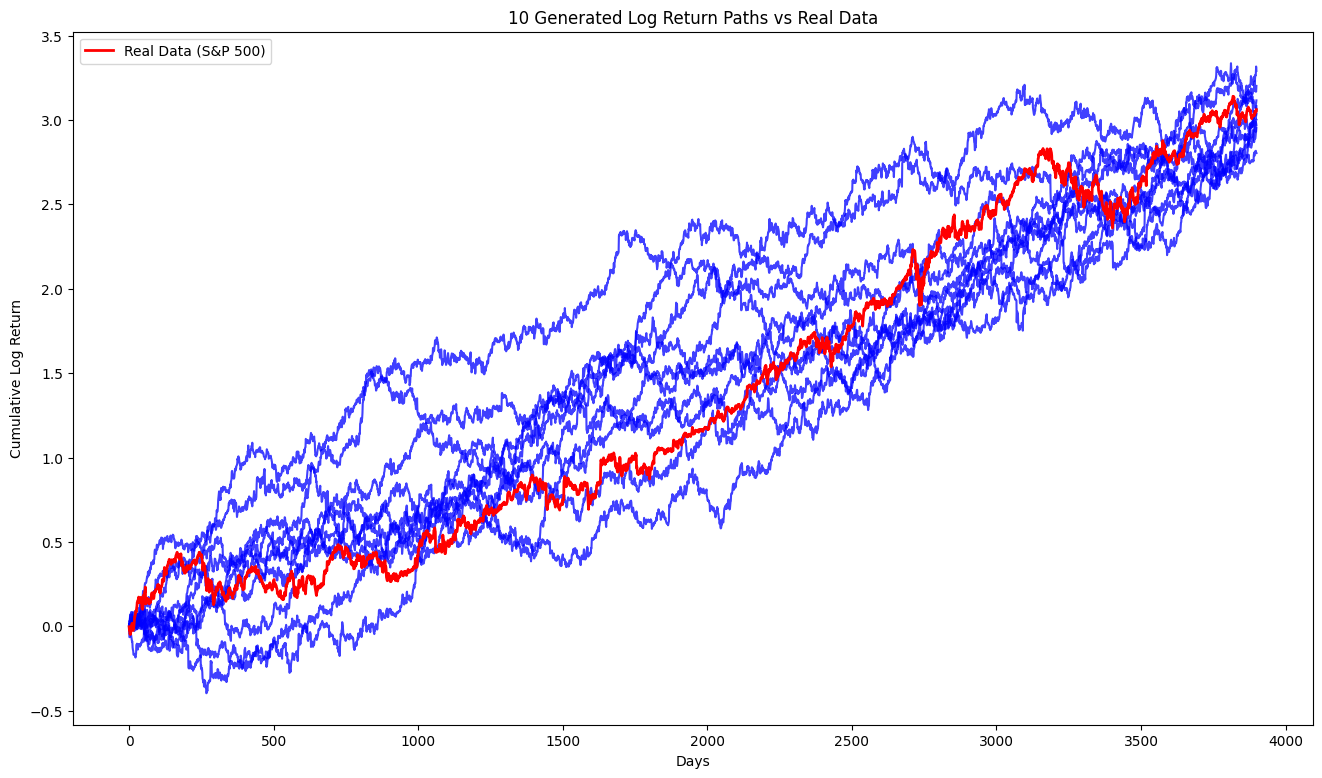

In [17]:
fig, ax = plt.subplots(figsize=(16, 9))

# Plot the cumulative sum of the generated paths
ax.plot(np.cumsum(y2[:10], axis=1).T, alpha=0.75, color='blue')

# Calculate the cumulative sum of sp500log for the first 127 days
real_data_cumsum = sp500log.cumsum()

# Plot the cumulative sum of the real data using day numbers (1 to 127) on the x-axis
ax.plot(range(0, 3900), real_data_cumsum, color='red', linewidth=2, label='Real Data (S&P 500)')

# Set labels and title
ax.set_title('10 Generated Log Return Paths vs Real Data')
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative Log Return')
ax.legend()

plt.show()



     

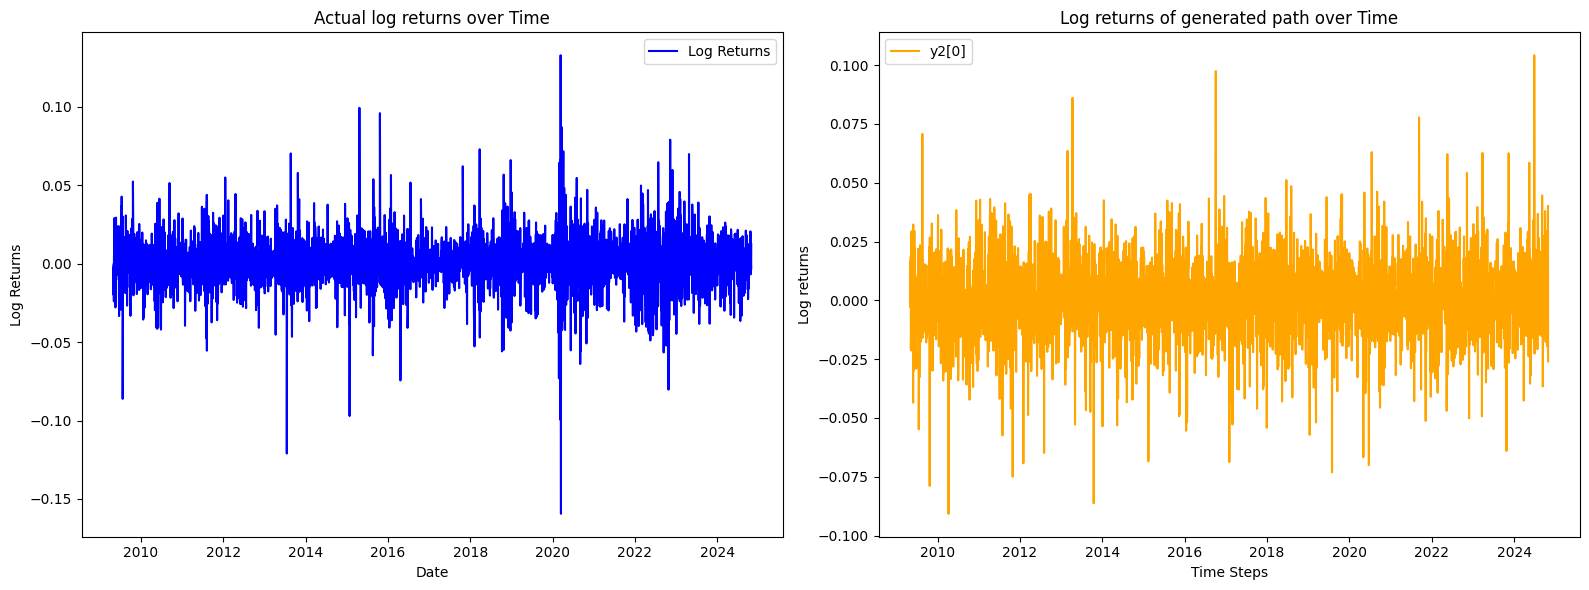

In [29]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Log Returns over time
ax[0].plot(sp500log.index, sp500log.values, color='blue', label='Log Returns')
ax[0].set_title('Actual log returns over Time')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Log Returns')
ax[0].legend()

# Plot 2: y2[0] over time
time_points = range(len(y2[0]))  # Assuming y2[0] is a time series
ax[1].plot(sp500log.index, y2[0], color='orange', label='y2[0]')
ax[1].set_title('Log returns of generated path over Time')
ax[1].set_xlabel('Time Steps')
ax[1].set_ylabel('Log returns')
ax[1].legend()

plt.tight_layout()
plt.show()

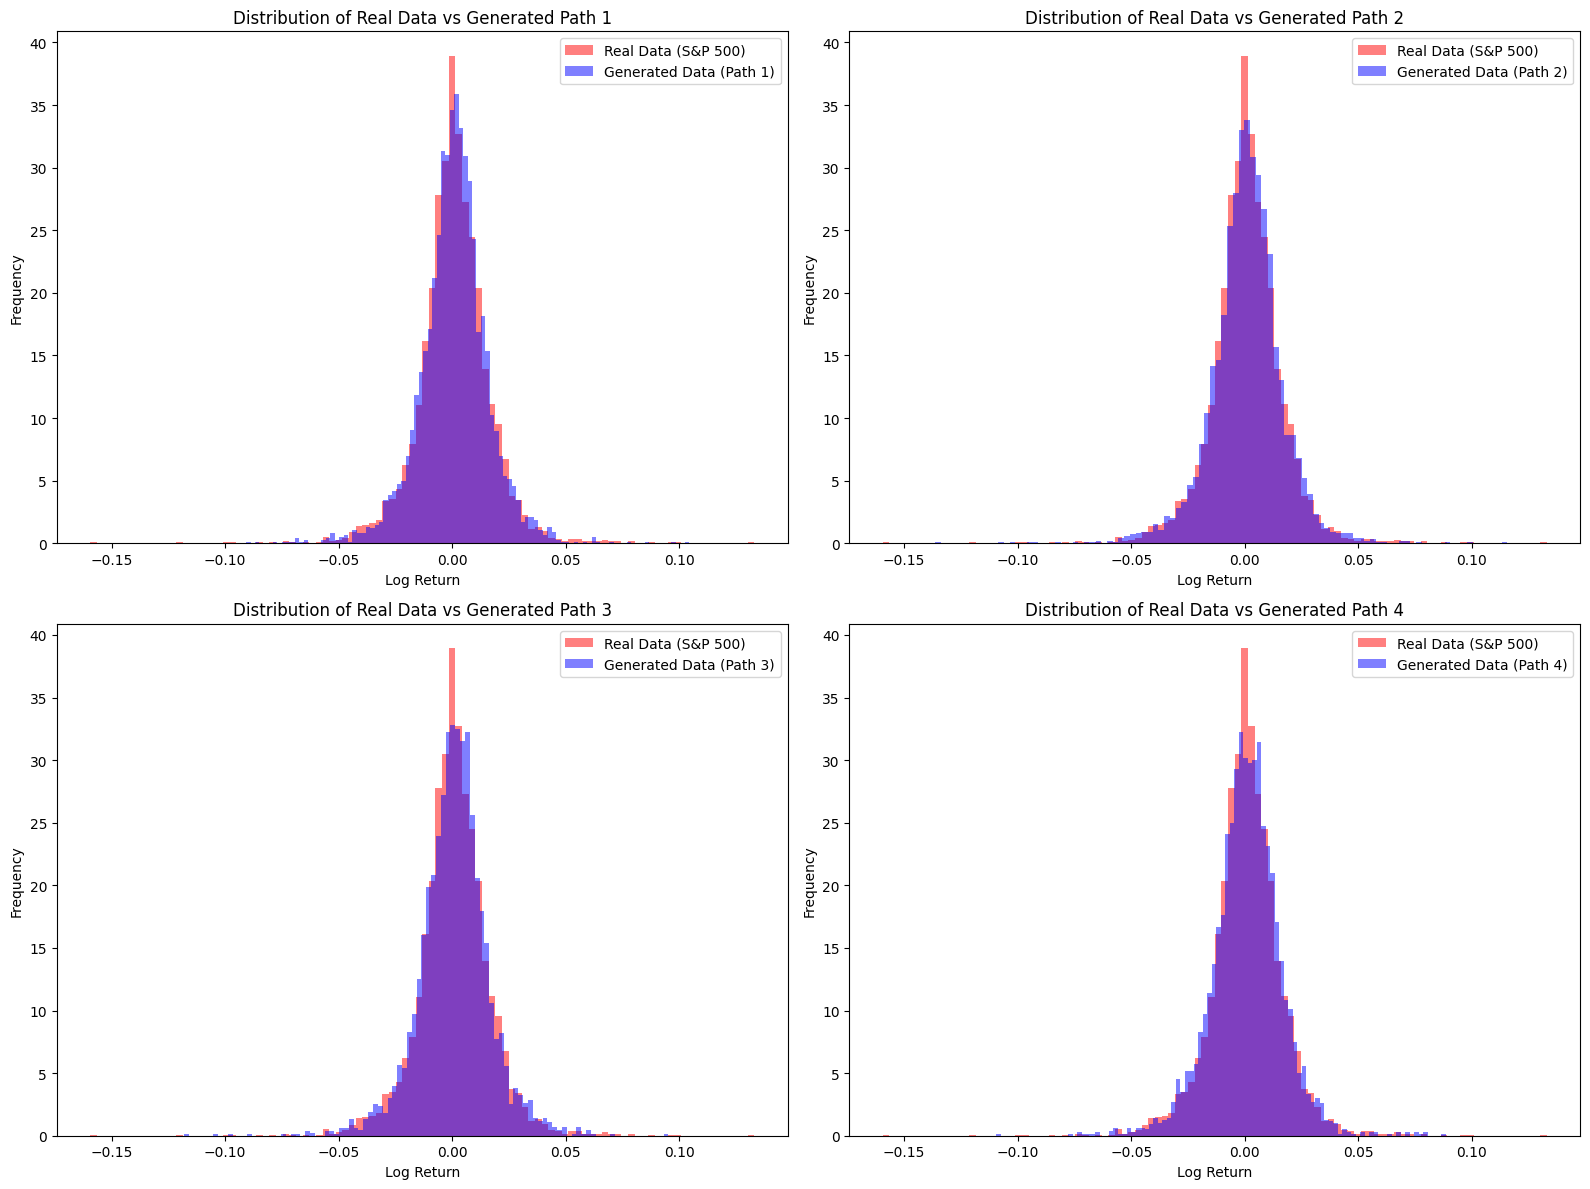

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))  # Create a 2x2 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easy iteration

bins = 100  # Number of bins for the histograms

# Loop through the first 4 sample paths and create histograms
for i in range(4):
    axes[i].hist(sp500log[:3900], bins=bins, density=True, alpha=0.5, label='Real Data (S&P 500)', color='red')
    axes[i].hist(y2[i][:3900], bins=bins, density=True, alpha=0.5, label=f'Generated Data (Path {i+1})', color='blue')
    
    # Set titles, labels, and legend for each plot
    axes[i].set_title(f'Distribution of Real Data vs Generated Path {i+1}')
    axes[i].set_xlabel('Log Return')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

In [14]:
y_df.to_csv('./data/' + ticker + '_GAN_generated_data.csv')
sp500log.to_csv('./data/' + ticker + '_actual_data.csv')